In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

%matplotlib inline
pd.options.display.max_columns = 32

# データ準備

In [2]:
PROJECT_ROOT_PATH = "../../"

datapath = PROJECT_ROOT_PATH + "lab_competition/data/"
outpath = PROJECT_ROOT_PATH + "lab_competition/output/01/"

# sudachiの小さい辞書をインポート
!pip install pyproject-toml
!pip install sudachipy sudachidict_core
!pip install scikit-learn

import numpy as np
import collections


In [3]:
# 各データを読み込みリストに格納
def read_file(path):
    with open(path, mode="r") as f:
        result = f.read().splitlines()
    return result

train_text = read_file(datapath + "text.train.txt")
dev_text = read_file(datapath + "text.dev.txt")
test_text = read_file(datapath + "text.test.txt")
train_label = np.loadtxt(datapath + "label.train.txt")
dev_label = np.loadtxt(datapath + "label.dev.txt")

In [4]:
# Tokeize

!pip install sudachipy
!pip install sudachidict_full


# テキストを眺める

In [5]:
train_text_df = pd.DataFrame({"label" :[str(int(l)) for l in train_label], "text" :train_text})
train_text_df.head()

,label,text
0,0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…
1,1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...
2,0,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。
3,0,眠い、眠れない。
4,0,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!


In [6]:
train_text_df.describe()

,label,text
count,30000,30000
unique,5,29867
top,0,森拓郎さんのストレッチDVD30日全身コース。
freq,9227,24


In [7]:
train_text_df.groupby('label').describe()

text                                     
      count unique                      top freq
label                                           
-1     5593   5587                      しんど    2
-2     3543   3522                       はー    6
0      9227   9178  森拓郎さんのストレッチDVD30日全身コース。   24
1      7760   7747                    朝マック！    4
2      3877   3872                 しごおわりあん！    2

In [8]:
train_text_df['message_len'] = train_text_df.text.apply(len)
train_text_df.head()

,label,text,message_len
0,0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,30
1,1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,51
2,0,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,34
3,0,眠い、眠れない。,8
4,0,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,47


Text(0.5, 0, 'Message Length')

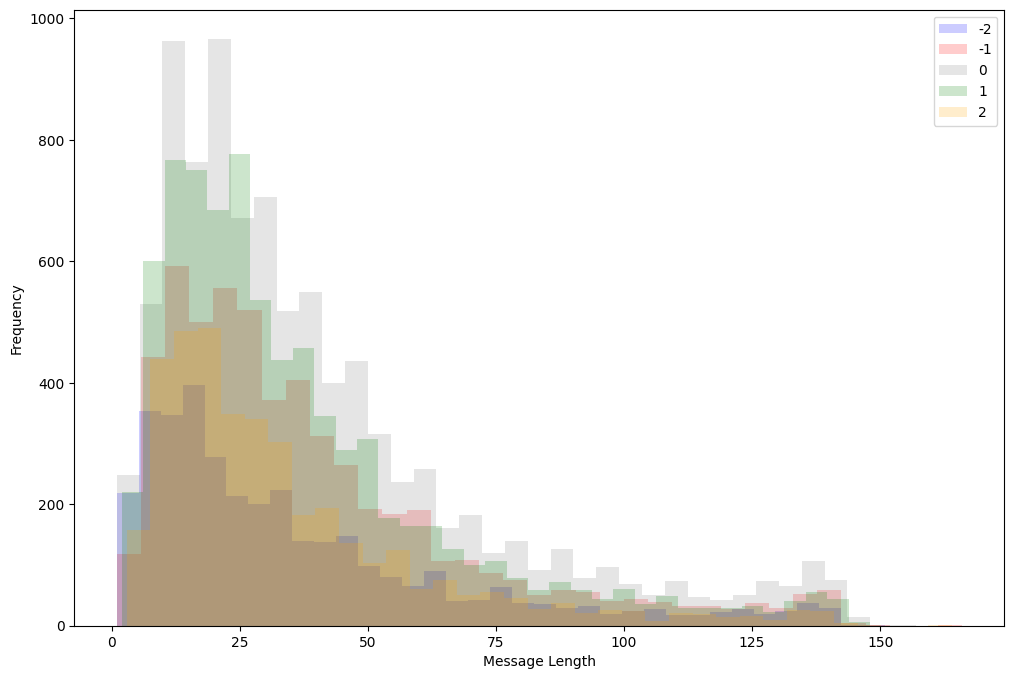

In [9]:
plt.figure(figsize=(12, 8))

train_text_df[train_text_df.label=='-2'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='-2', alpha=0.2)
train_text_df[train_text_df.label=='-1'].message_len.plot(bins=35, kind='hist', color='red', 
                                       label='-1', alpha=0.2)
train_text_df[train_text_df.label=='0'].message_len.plot(bins=35, kind='hist', color='gray', 
                                       label='0', alpha=0.2)
train_text_df[train_text_df.label=='1'].message_len.plot(bins=35, kind='hist', color='green', 
                                       label='1', alpha=0.2)
train_text_df[train_text_df.label=='2'].message_len.plot(bins=35, kind='hist', color='orange', 
                                       label='2', alpha=0.2)
plt.legend()
plt.xlabel("Message Length")

In [10]:
train_text_df[train_text_df.label=='-2'].describe()

,message_len
count,3543.000000
mean,36.483489
std,32.318008
min,1.000000
25%,13.000000
50%,26.000000
75%,49.000000
max,151.000000


In [11]:
train_text_df[train_text_df.label=='-1'].describe()

,message_len
count,5593.000000
mean,39.158949
std,30.501219
min,1.000000
25%,18.000000
50%,30.000000
75%,51.000000
max,166.000000


In [12]:
train_text_df[train_text_df.label=='0'].describe()

,message_len
count,9227.000000
mean,40.388534
std,31.809770
min,1.000000
25%,17.000000
50%,31.000000
75%,52.000000
max,157.000000


In [13]:
train_text_df[train_text_df.label=='1'].describe()

,message_len
count,7760.000000
mean,36.672423
std,28.797956
min,2.000000
25%,16.000000
50%,28.000000
75%,47.000000
max,148.000000


In [14]:
train_text_df[train_text_df.label=='2'].describe()

,message_len
count,3877.000000
mean,34.497808
std,27.496652
min,3.000000
25%,16.000000
50%,26.000000
75%,43.000000
max,164.000000


# 単語分割

In [15]:
from sudachipy import tokenizer
from sudachipy import dictionary
from itertools import chain

tokenizer_obj = dictionary.Dictionary(dict="full").create()
mode = tokenizer.Tokenizer.SplitMode.C

# 前処理
def text_cleaning(textlist, mode, clear_part_of_speech_list, stopword_list):
    morphemelist = [tokenizer_obj.tokenize(text, mode) for text in textlist]
    result = []
    for morpheme in morphemelist:
        words = []
        for word in morpheme:
            if word.part_of_speech()[0] not in clear_part_of_speech_list[0]:
                if word.part_of_speech()[1] not in clear_part_of_speech_list[1]:
                    if word.normalized_form() not in stopword_list:
                        words.append(word.normalized_form())
        result.append(" ".join(words))
    return result

In [16]:
clear_part_of_speech_list = [["助詞", "助動詞"],["数詞"]]

with open(datapath + "stopwords.txt") as f:
    stopword_list = f.read().splitlines()

print(stopword_list)

train_data = text_cleaning(train_text, mode, clear_part_of_speech_list, stopword_list)
dev_data = text_cleaning(dev_text, mode, clear_part_of_speech_list, stopword_list)
test_data = text_cleaning(test_text, mode, clear_part_of_speech_list, stopword_list)

['。', '、', '.', '為る', '成る', '居る', 'とこ', ':', '/', '_', '-', '〜', '(', ')', '私', '御', '」', '「', '人', '物', 'ー', '言う', 'こと', '見る', '行く', '・', 'さん', 'ちゃん', 'そう', 'よう', ';', '`', '分', '今', '今日', '日', '有る', '又', '来る', '思う', '此の', '時']


In [17]:
train_text_df['clean_msg'] = train_data
train_text_df.head()

,label,text,message_len,clean_msg
0,0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,30,ぼけっと こんな 時間 ちゃり 食べる 出る
1,1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,51,月 白い 明るい 昨日 雲 少ない 奇麗 立ち止まる 帰り道 ちゃり なし 生活 悪い 無い
2,0,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,34,早寝 積もり 飲み物 なくなる コンビニ んっ 風 涼しい
3,0,眠い、眠れない。,8,眠い 眠る
4,0,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,47,只今 新体操 ! 外食 気 満々 家 何 無い ! テレビ 離れる !


## ラベルごとの頻出単語

In [18]:
import collections
words = train_text_df[train_text_df.label=='-2'].clean_msg.apply(lambda x: x.split())
negativeL_words = collections.Counter()

for msg in words:
    negativeL_words.update(msg)

print(-2)
print(negativeL_words.most_common(200))


words = train_text_df[train_text_df.label=='-1'].clean_msg.apply(lambda x: x.split())
negativeS_words = collections.Counter()

for msg in words:
    negativeS_words.update(msg)
    
print("\n\n{}".format(-1))
print(negativeS_words.most_common(200))


words = train_text_df[train_text_df.label=='0'].clean_msg.apply(lambda x: x.split())
neutral_words = collections.Counter()

for msg in words:
    neutral_words.update(msg)

print("\n\n{}".format(0))
print(neutral_words.most_common(200))


words = train_text_df[train_text_df.label=='1'].clean_msg.apply(lambda x: x.split())
positiveS_words = collections.Counter()

for msg in words:
    positiveS_words.update(msg)

print("\n\n{}".format(1))
print(positiveS_words.most_common(200))


words = train_text_df[train_text_df.label=='2'].clean_msg.apply(lambda x: x.split())
positiveL_words = collections.Counter()

for msg in words:
    positiveL_words.update(msg)
    
print("\n\n{}".format(2))
print(positiveL_words.most_common(200))

-2
[('!', 845), ('無い', 617), ('…', 408), ('何', 365), ('?', 357), ('良い', 269), ('仕事', 221), ('もう', 194), ('過ぎる', 192), ('寝る', 164), ('仕舞う', 156), ('遣る', 153), ('出来る', 146), ('時間', 140), ('どう', 136), ('自分', 132), ('明日', 132), ('分かる', 117), ('辛い', 113), ('本当', 110), ('悪い', 107), ('終わる', 103), ('其れ', 99), ('帰る', 96), ('ああ', 94), ('此れ', 92), ('呉れる', 90), ('気', 90), ('出る', 89), ('食べる', 87), ('欲しい', 86), ('嫌', 85), ('後', 83), ('使う', 79), ('無理', 79), ('未だ', 79), ('^q^', 77), ('前', 76), ('方', 74), ('考える', 73), ('痛い', 73), ('悲しい', 72), ('中', 71), ('こんな', 71), ('眠い', 68), ('聞く', 67), ('まじ', 67), ('疲れる', 67), ('みたい', 65), ('頑張る', 65), ('買う', 63), ('年', 63), ('其の', 62), ('やめる', 61), ('気持ち', 60), ('目', 59), ('死ぬ', 58), ('会社', 58), ('朝', 57), ('凄い', 56), ('一寸', 56), ('起きる', 56), ('あー', 55), ('家', 55), ('怖い', 55), ('頭', 54), ('話', 53), ('はあ', 53), ('忘れる', 53), ('多い', 51), ('早い', 50), ('月', 50), ('最近', 50), ('為', 49), ('誰', 49), ('所', 48), ('作る', 48), ('御腹', 48), ('そんな', 47), ('職場', 47), ('入る', 47), ('

# 線形回帰を回してみる

In [27]:
# 出現頻度が少ない単語をstopwordとする
def stopwords_occur(textlist, threshold):
    morphemelist = [tokenizer_obj.tokenize(text, mode) for text in textlist]
    words = []
    for morpheme in morphemelist:
        for word in morpheme:
            words.append(word.normalized_form())
    dic = collections.Counter(words)
    dic = {key:value for key, value in dic.items() if value<= threshold}
    return list(dic.keys())

clear_part_of_speech_list = [["助詞", "助動詞"],["数詞"]]

with open(datapath + "stopwords.txt") as f:
    stopword_list = f.read().splitlines()

stopword_occur = stopwords_occur(train_text, 2)

stopword_list.extend(stopword_occur)
print(stopword_list)

train_data = text_cleaning(train_text, mode, clear_part_of_speech_list, stopword_list)
dev_data = text_cleaning(dev_text, mode, clear_part_of_speech_list, stopword_list)
test_data = text_cleaning(test_text, mode, clear_part_of_speech_list, stopword_list)

['。', '、', '.', '為る', '成る', '居る', 'とこ', ':', '/', '_', '-', '〜', '(', ')', '私', '御', '」', '「', '人', '物', 'ー', '言う', 'こと', '見る', '行く', '・', 'さん', 'ちゃん', 'そう', 'よう', ';', '`', '分', '今', '今日', '日', '有る', '又', '来る', '思う', '此の', '時', '新体操', '表情筋', 'シャレード', 'モテキ', '小宮山', '夏樹', 'バッティングセンター', 'COWCOW', 'BIGBANG', '笑む', '立石', '生半可', '達者', 'たんと', 'しい', '外反母趾', '昔夢', 'チョコケーキ', '天地明察', '不確か', '連れ去る', '微か', '絡み付く', '投げ掛ける', '茶碗蒸し', 'シナモンロール', '́з', '2700', 'wy', '愛と誠', '在り来り', 'ミランダ', 'カー', 'お子様', '岩', '整骨院', 'テーピング', '丸腰', '整体', '釣れる', '自己否定', '自己肯定', '鬼太郎', '彦', '門', '豚骨', '茄子', '田楽', 'パトラッシュ', 'エビマヨ', '煮', 'ふじ', 'ピール', 'なか卯', 'ジャーナリスト', '祈り', 'さめる', 'メルヘン', '齧り付く', '同志', '求', '本が好き', '立ち読み', '流し読み', 'standardbookstore', 'ノーベル賞', '山中', '育む', '西田辺', '割り箸', 'ニーハイ', '歯痒い', '信託', '別口', '著作', '田中里奈', 'たなか', 'りな', 'ティーナカリーナ', 'キョンキョン', '悪の教典', 'ニモ', 'ケズ', '出家', 'がぶり', 'カブレ', 'たらふく', 'ホームパーティー', '祭りのあと', 'BARBEE BOYS', '差し込む', 'はだける', '生田斗真', 'てれび戦士', '精神年齢', '体年齢', '串カツ', '有耶無耶', '怪しむ', '挙式', '緩巻き', '冠

In [28]:
!pip install lightgbm

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,1))
train_tfidf = vectorizer.fit_transform(train_data)
dev_tfidf = vectorizer.transform(dev_data)
test_tfidf = vectorizer.transform(test_data)

train_vec = train_tfidf.toarray()
dev_vec = dev_tfidf.toarray()
test_vec = test_tfidf.toarray()

print("train = " + str(train_vec.shape))
print("trainlabel = " + str(train_label.shape))
print("dev = " + str(dev_vec.shape))
print("devlabel = " + str(dev_label.shape))
print("test = " + str(test_vec.shape))

train = (30000, 9801)
trainlabel = (30000,)
dev = (2500, 9801)
devlabel = (2500,)
test = (2500, 9801)


In [30]:
# scikit-lean実装

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

lightgbm_model = lgb.LGBMClassifier(n_estimators=10000, verbose=-1)

param_lgb = {
    'objective'         : 'multiclass',
    'metric'       : ['multi_logloss'],
    'num_class'         : [5],
    "subsample"         : np.arange(0.5, 1.0, 0.1),
    "subsample_freq"    : [1, 2, 4, 8, 16, 32, 64, 128, 256],
    "reg_lambda"        : [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0],
    "learning_rate"     : [0.2 ,0.05, 0.01],
    "lambda_l1"         : sp.stats.uniform(1e-8, 10.0),
    "lambda_l2"         : sp.stats.uniform(1e-8, 10.0),
    "num_leaves"        : sp.stats.randint(2, 512),
    "feature_fraction"  : sp.stats.uniform(0.4, 0.6),
    "bagging_fraction"  : sp.stats.uniform(0.4, 0.6),
    "bagging_freq"      : sp.stats.randint(2, 10),
    "min_child_samples" : sp.stats.randint(5, 100)
}


randcv = RandomizedSearchCV(estimator=lightgbm_model, param_distributions=param_lgb, scoring="accuracy", n_jobs=3, verbose=3, cv=2, random_state = 47, n_iter=500)

fit_params = {"callbacks": [lgb.early_stopping(
                  stopping_rounds=100, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                  verbose=3)],  # 学習中のコマンドライン出力
              "eval_metric": 'multiclass',  # early_stopping_roundsの評価指標
              "eval_set": [(dev_vec, dev_label)]  # early_stopping_roundsの評価指標算出用データ
              }

# ランダムサーチ実行（学習実行）
randcv.fit(train_vec, train_label, **fit_params)

# 最適パラメータの表示と保持
best_params = randcv.best_params_
best_score = randcv.best_score_
print(f"最適パラメータ {best_params}\nスコア {best_score}")

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[LightGBM] [Warning] lambda_l1 is set=3.9959372753607982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9959372753607982
[LightGBM] [Warning] bagging_fraction is set=0.5479896290647852, subsample=0.7 will be ignored. Current value: bagging_fraction=0.5479896290647852
[LightGBM] [Warning] lambda_l2 is set=3.544379430610996, reg_lambda=1e-07 will be ignored. Current value: lambda_l2=3.544379430610996
[LightGBM] [Warning] feature_fraction is set=0.7084051625013859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7084051625013859
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=1 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 1.50513
[CV 1/2] END bagging_fraction=0.5479896290647852, bagging_freq=9, feature_fraction=0.7084051625013859, lambda_l1=3.9959372753

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] lambda_l1 is set=7.995777208221898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.995777208221898
[LightGBM] [Warning] bagging_fraction is set=0.9515038425827126, subsample=0.8999999999999999 will be ignored. Current value: bagging_fraction=0.9515038425827126
[LightGBM] [Warning] lambda_l2 is set=2.8406062219887764, reg_lambda=0.001 will be ignored. Current value: lambda_l2=2.8406062219887764
[LightGBM] [Warning] feature_fraction is set=0.4801088226507616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4801088226507616
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=16 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 1.49446
[CV 2/2] END bagging_fraction=0.9515038425827126, bagging_freq=9, feature_fraction=0.4801088226507616, lambda_l1=7.995777208221898, lambda_l2=2.8406062219887764, learning_ra

In [31]:
import pandas as pd

results = pd.DataFrame(randcv.cv_results_)
best_estimator = randcv.best_estimator_

display(results[results["rank_test_score"] <= 10])
print(best_estimator)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_feature_fraction,param_lambda_l1,param_lambda_l2,param_learning_rate,param_metric,param_min_child_samples,param_num_class,param_num_leaves,param_objective,param_reg_lambda,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
81,23.508597,2.745423,2.695441,0.908180,0.944765,6,0.850137,4.934807,5.964912,0.01,multi_logloss,24,5,54,a,0.00001,0.5,256,"{'bagging_fraction': 0.9447645033556015, 'bagg...",0.335733,0.334267,0.335000,0.000733,10
98,10.930890,0.030695,0.572038,0.016450,0.781611,6,0.450322,3.217934,9.766367,0.05,multi_logloss,11,5,47,i,0.000001,0.8,64,"{'bagging_fraction': 0.7816107335042664, 'bagg...",0.335800,0.334733,0.335267,0.000533,9
142,22.101219,1.723569,2.028142,0.210156,0.713462,2,0.772605,2.528727,1.883415,0.01,multi_logloss,10,5,7,s,0.000001,0.6,8,"{'bagging_fraction': 0.713462160051048, 'baggi...",0.338600,0.339800,0.339200,0.000600,3
177,39.800611,0.827871,2.456643,0.179142,0.596041,7,0.671049,2.888183,5.545352,0.01,multi_logloss,6,5,111,m,0.00001,0.5,1,"{'bagging_fraction': 0.5960408375598203, 'bagg...",0.335867,0.336067,0.335967,0.000100,8
237,25.044359,3.658995,2.345507,0.832782,0.932361,2,0.431527,2.96431,3.745915,0.01,multi_logloss,19,5,44,s,0,0.7,64,"{'bagging_fraction': 0.9323613273769479, 'bagg...",0.335733,0.336333,0.336033,0.000300,7
295,19.158522,1.144842,1.541038,0.325682,0.997311,5,0.840537,3.102167,0.089532,0.01,multi_logloss,13,5,24,i,0.000001,0.8,16,"{'bagging_fraction': 0.9973112473189107, 'bagg...",0.342067,0.339200,0.340633,0.001433,1
320,15.981256,1.096651,2.360892,0.259300,0.846944,5,0.8971,1.845047,4.68118,0.01,multi_logloss,25,5,12,l,0.00001,0.7,64,"{'bagging_fraction': 0.846944483941136, 'baggi...",0.338667,0.338600,0.338633,0.000033,4
346,5.756531,0.566233,0.317021,0.028647,0.917953,2,0.650475,0.784713,0.334943,0.05,multi_logloss,18,5,17,i,0.000001,0.5,64,"{'bagging_fraction': 0.9179530830715937, 'bagg...",0.337867,0.339067,0.338467,0.000600,5
375,9.568073,1.703233,0.711959,0.092591,0.966783,9,0.441516,4.403449,6.565202,0.05,multi_logloss,20,5,30,u,0.0001,0.7,1,"{'bagging_fraction': 0.9667825833440544, 'bagg...",0.337133,0.335867,0.336500,0.000633,6
433,8.516131,0.073302,0.458095,0.064904,0.957289,5,0.956459,2.024792,5.705082,0.05,multi_logloss,14,5,28,s,0.000001,0.5,32,"{'bagging_fraction': 0.9572892584046345, 'bagg...",0.339933,0.338867,0.339400,0.000533,2


LGBMClassifier(bagging_fraction=0.9973112473189107, bagging_freq=5,
               feature_fraction=0.8405368817955569,
               lambda_l1=3.1021671832151014, lambda_l2=0.0895315270426858,
               learning_rate=0.01, metric='multi_logloss', min_child_samples=13,
               n_estimators=10000, num_class=5, num_leaves=24, objective='i',
               reg_lambda=1e-06, subsample=0.7999999999999999,
               subsample_freq=16, verbose=-1)


# テスト出力

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

model = lgb.LGBMClassifier(bagging_fraction=0.9973112473189107, bagging_freq=5,
               feature_fraction=0.8405368817955569,
               lambda_l1=3.1021671832151014, lambda_l2=0.0895315270426858,
               learning_rate=0.01, metric='multi_logloss', min_child_samples=13,
               n_estimators=10000, num_class=5, num_leaves=24, objective='i',
               reg_lambda=1e-06, subsample=0.7999999999999999,
               subsample_freq=16, verbose=-1)
model.fit(train_vec, train_label)

LGBMClassifier(bagging_fraction=0.9973112473189107, bagging_freq=5,
               feature_fraction=0.8405368817955569,
               lambda_l1=3.1021671832151014, lambda_l2=0.0895315270426858,
               learning_rate=0.01, metric='multi_logloss', min_child_samples=13,
               n_estimators=10000, num_class=5, num_leaves=24, objective='i',
               reg_lambda=1e-06, subsample=0.7999999999999999,
               subsample_freq=16, verbose=-1)

In [33]:
dev_pred = model.predict(dev_vec)
acc = accuracy_score(dev_pred, dev_label)
print("正確率 = %.3f" % (acc))
print(classification_report(dev_label, dev_pred))

正確率 = 0.344
              precision    recall  f1-score   support

        -2.0       0.28      0.10      0.15       310
        -1.0       0.30      0.24      0.27       415
         0.0       0.31      0.61      0.41       647
         1.0       0.44      0.36      0.40       837
         2.0       0.28      0.11      0.16       291

    accuracy                           0.34      2500
   macro avg       0.32      0.29      0.28      2500
weighted avg       0.35      0.34      0.32      2500



In [34]:
# test出力
test_pred = model.predict(test_vec)

np.savetxt(outpath + "/leaderboad/v0.0.3_LightGBM.txt", test_pred, fmt="%.0f")